In [54]:
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import cmasher as cmr
cmap = cmr.dusk
import smtplib
%config InlineBackend.figure_format = "retina"


from tqdm import tqdm
import joblib 

import sys
sys.path.append("/home/jdli/transpec")

import time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
from kvxp.data import GXP_4lb,  XPAP4l

from kvxp.xpformer import MLP, MLP_upsampling
from kvxp.utils import *
from kvxp.vis import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:

BATCH_SIZE = int(2**12)
num_epochs = 500
part_train = False


def recover_scale_label(y, e_y, scaler_name='../models/scaler_labels_0330.gz'):
    scaler_labels = joblib.load(scaler_name)
    y   = scaler_labels.inverse_transform(y)
    e_y = e_y * scaler_labels.scale_
    return y, e_y

def infer_4lbs_ap(data_loader, model, transcale_method=recover_scale_label, 
                     device=torch.device('cuda:1'), 
                     pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp'],
                     true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M'],
                     e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR'],
                     ):
    
    out_lst = np.array([])
    y_lst = np.array([])
    e_y_lst = np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            # output = model(data['ap'])
            output = model(data['xp'])
            out_lst   = np.append(out_lst,   output[:,:4].cpu().numpy())
            
            y_lst    = np.append(y_lst, data['y'].cpu().numpy())
            e_y_lst  = np.append(e_y_lst, data['e_y'].cpu().numpy())
            id_batch =  list(data['id'])
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,4)
    y_lst = np.array(y_lst).reshape(-1,4)
    e_y_lst = np.array(e_y_lst).reshape(-1,4)
    
    y_pred, _ = transcale_method(out_lst, out_lst)
    y_true, e_y_lst= transcale_method(y_lst, y_lst)
    
    rdf = pd.DataFrame(np.c_[y_true, y_pred, e_y_lst, id_lst], 
                       columns=true_names+pred_names+e_true_names+['source_id'])
    
    rdf.source_id = rdf.source_id.astype(int).astype(str)
    rdf = rdf.reset_index(drop=True)
    return rdf


def infer_4lbs_model(data_loader,
                     encoder, decoder, transcale_method=recover_scale_label, 
                     device=torch.device('cuda:0'), 
                     pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp'],
                     e_pred_names = ['e_teff_xp', 'e_logg_xp',  'e_moh_xp', 'e_aom_xp'],
                     true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M'],
                     e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR'],
                     ):
    
    out_lst = np.array([])
    y_lst = np.array([])
    e_out_lst = np.array([])
    e_y_lst = np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            z = encoder(data['xp'])
            output = decoder(z)
            
            out_lst   = np.append(out_lst,   output[:,:4].cpu().numpy())
            e_out_lst = np.append(e_out_lst, output[:,4:].cpu().numpy())
            # e_out_lst = np.append(e_out_lst, output[:,:4].cpu().cpu().numpy())
            
            y_lst    = np.append(y_lst, data['y'].cpu().numpy())
            e_y_lst  = np.append(e_y_lst, data['e_y'].cpu().numpy())
            id_batch =  list(data['id'])
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,4)
    e_out_lst = np.abs(e_out_lst).reshape(-1,4)
    y_lst = np.array(y_lst).reshape(-1,4)
    e_y_lst = np.array(e_y_lst).reshape(-1,4)
    
    y_pred, e_pred = transcale_method(out_lst, e_out_lst)
    y_true, e_y_lst= transcale_method(y_lst, e_y_lst)
    
     # {'labels_true':y_true, 'labels_pred':y_pred, '', 'source_id':id_lst}
    rdf = pd.DataFrame(np.c_[y_true, y_pred, e_pred, e_y_lst, id_lst], 
                       columns=true_names+pred_names+e_pred_names+e_true_names+['source_id'])
    rdf.source_id = rdf.source_id.astype(int).astype(str)
    rdf = rdf.reset_index(drop=True)
    return rdf


In [55]:
"""
data params
"""
data_dir = "/data/jdli/gaia/"
tr_file ="apspec_xp_cut_0415.dump" #467993 data
device = torch.device('cuda:1')

# gdata  = GXP_4lb(data_dir+tr_file, device=device, part_train=False)
gdata  = XPAP4l(data_dir+tr_file, device=device, part_train=False)

"""
model params
"""

model_dir = f"/data/jdli/gaia/model/0418/"

In [59]:
fold = 0
epoch = 550

n_lat = 1024
n_xp = 110
n_ap = 8575
n_labels = 8


model_point = model_dir + f"xp2_4l_{fold}_ep{100}.pt"
enc_point = model_dir + f"xp2_lat_{fold}_ep{epoch}.pt"
# dec_point = model_dir + f"lat2_4l_{fold}_ep{epoch}.pt"
dec_point = model_dir + f"lat2_4lerr_{fold}_ep{epoch}.pt"
# hal_point = model_dir + f"ap2_4l_{fold}_ep50.pt"

model = MLP(n_xp, 4).to(device)
decoder = MLP(n_lat, n_labels).to(device)
encoder = MLP_upsampling(n_xp, n_lat, hidden_size=256).to(device)
# hal = MLP(n_ap, 4).to(device)


# model.load_state_dict(
#     remove_prefix(
#         torch.load(model_point)
#     )
# )

encoder.load_state_dict(
    remove_prefix(
        torch.load(enc_point)
    )
)
decoder.load_state_dict(
    remove_prefix(
        torch.load(dec_point)
    ))
# hal.load_state_dict(
#     remove_prefix(
#         torch.load(hal_point)
#     )
# )

<All keys matched successfully>

In [35]:
pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
BATCH_SIZE = int(2**12)
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)

        rdf_xp = infer_4lbs_ap(
            val_loader, model, device=device, 
            transcale_method=recover_scale_label,
        )
        
print(rdf_xp.shape)
# rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", how='left')
rdf_xp.head(3)

FOLD 0
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.45s/it]


(28426, 13)


,TEFF,LOGG,M_H,ALPHA_M,teff_xp,logg_xp,moh_xp,aom_xp,TEFF_ERR,LOGG_ERR,M_H_ERR,ALPHA_M_ERR,source_id
0,4112.826643,4.632454,-0.099435,-0.043354,4165.934930,4.607180,-0.054857,-0.046926,-591.484880,2.086326,0.068985,-0.086196,1601762255808253952
1,3917.667515,1.105035,-0.225990,0.044785,3931.026915,1.078820,-0.257678,0.042845,-786.644008,-1.441092,-0.057570,0.001943,511361868581739008
2,4787.778321,2.504554,0.054056,0.008270,4760.507415,2.489969,-0.005212,0.015778,83.466797,-0.041574,0.222476,-0.034572,4658253531324747776


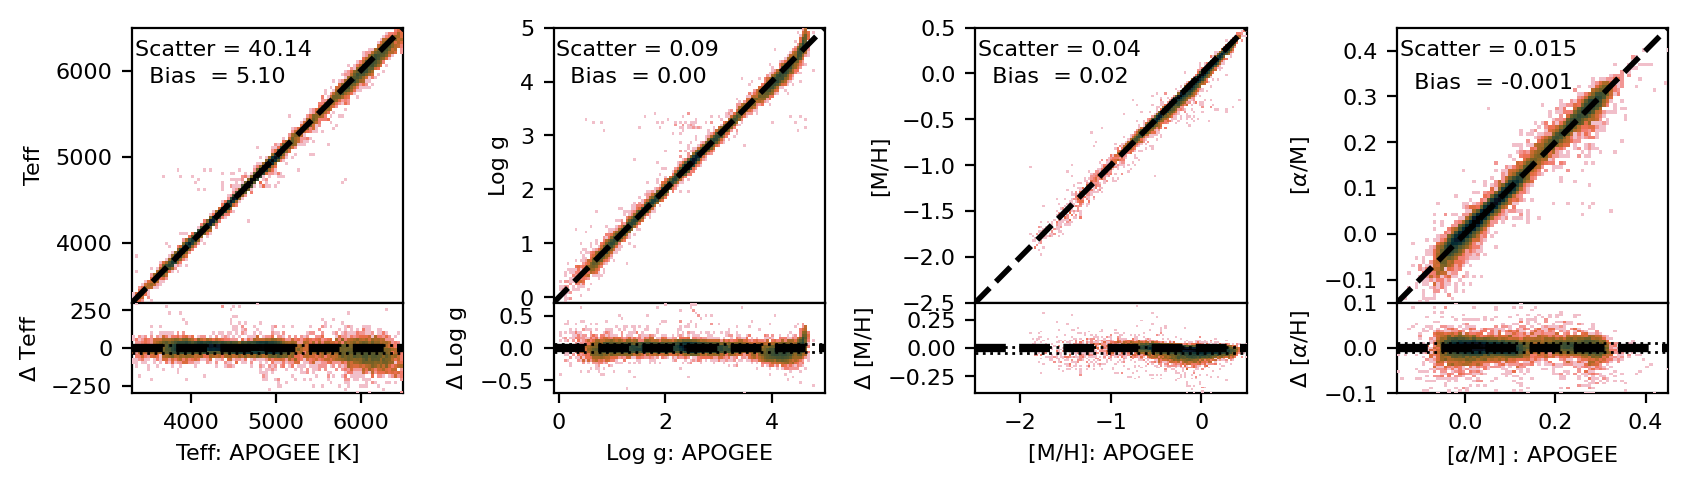

In [53]:

ind = rdf_xp['logg_xp'] < 5

fig, axs = plt.subplots(1,4, figsize=(8.5, 2.5))

rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.4, 0.4], [-0.1, 0.1]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]
    
for i in range(4):
    ynames = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
    
    text_stats_default = False if i==3 else True

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_xp[ind][true_names[i]], rdf_xp[ind][ynames[i]],
        xrange=xranges[i], bins=100, text_stats=text_stats_default,
        cmap='cmr.dusk_r'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);
    
    if i==3:
        res = rdf_xp[ind][true_names[i]]-rdf_xp[ynames[i]]
        ax1.text(0.01, 0.9, "Scatter = %.3f"%(np.std(res)),
                transform=ax1.transAxes, zorder=6)
        ax1.text(0.01, 0.78, "  Bias  = %.3f"%(np.mean(res)),
                transform=ax1.transAxes, zorder=6)
    
plt.tight_layout()

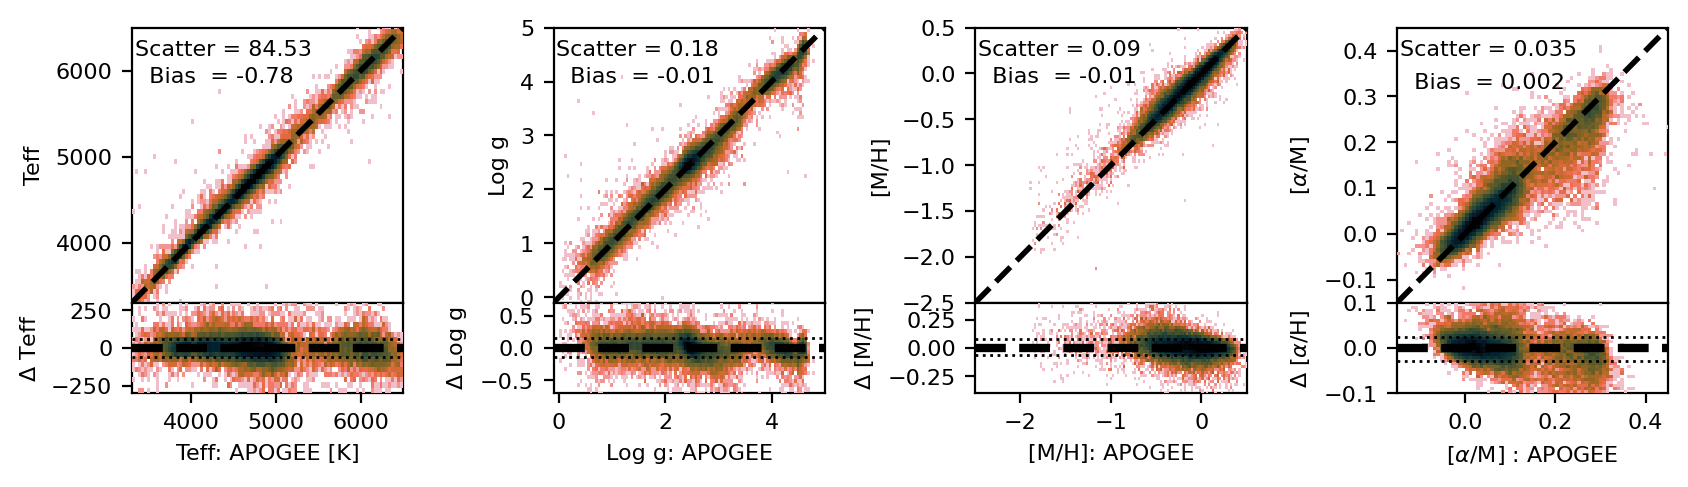

In [36]:
ind = rdf_xp['logg_xp'] < 5

fig, axs = plt.subplots(1,4, figsize=(8.5, 2.5))

rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.4, 0.4], [-0.1, 0.1]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]
    
for i in range(4):
    ynames = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
    
    text_stats_default = False if i==3 else True

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_xp[ind][true_names[i]], rdf_xp[ind][ynames[i]],
        xrange=xranges[i], bins=100, text_stats=text_stats_default,
        cmap='cmr.dusk_r'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);
    
    if i==3:
        res = rdf_xp[ind][true_names[i]]-rdf_xp[ynames[i]]
        ax1.text(0.01, 0.9, "Scatter = %.3f"%(np.std(res)),
                transform=ax1.transAxes, zorder=6)
        ax1.text(0.01, 0.78, "  Bias  = %.3f"%(np.mean(res)),
                transform=ax1.transAxes, zorder=6)
    
plt.tight_layout()

# validation

In [60]:
pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
BATCH_SIZE = int(2**12)
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)

        rdf_xp = infer_4lbs_model(
            val_loader, encoder, decoder, device=device, 
            transcale_method=recover_scale_label,
        )
        
print(rdf_xp.shape)
rdf_xp.head(3)

FOLD 0
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.19it/s]


(28426, 17)


,TEFF,LOGG,M_H,ALPHA_M,teff_xp,logg_xp,moh_xp,aom_xp,e_teff_xp,e_logg_xp,e_moh_xp,e_aom_xp,TEFF_ERR,LOGG_ERR,M_H_ERR,ALPHA_M_ERR,source_id
0,4459.669914,2.138534,-0.327090,0.234055,4406.834823,1.993905,-0.365387,0.217982,23.799209,0.062106,0.032753,0.022157,6.931325,0.024438,0.007006,0.006110,978373140344250240
1,5903.771009,4.352169,-0.083906,-0.009591,5808.538170,4.299211,-0.069928,-0.007719,60.449578,0.066372,0.039651,0.011358,31.489326,0.022219,0.005250,0.008450,690748599395272960
2,4022.180152,0.788964,-0.998720,0.158405,4054.821335,0.848598,-1.127573,0.149029,30.904702,0.066943,0.082089,0.034449,6.127294,0.032290,0.009768,0.009109,829409866211754880


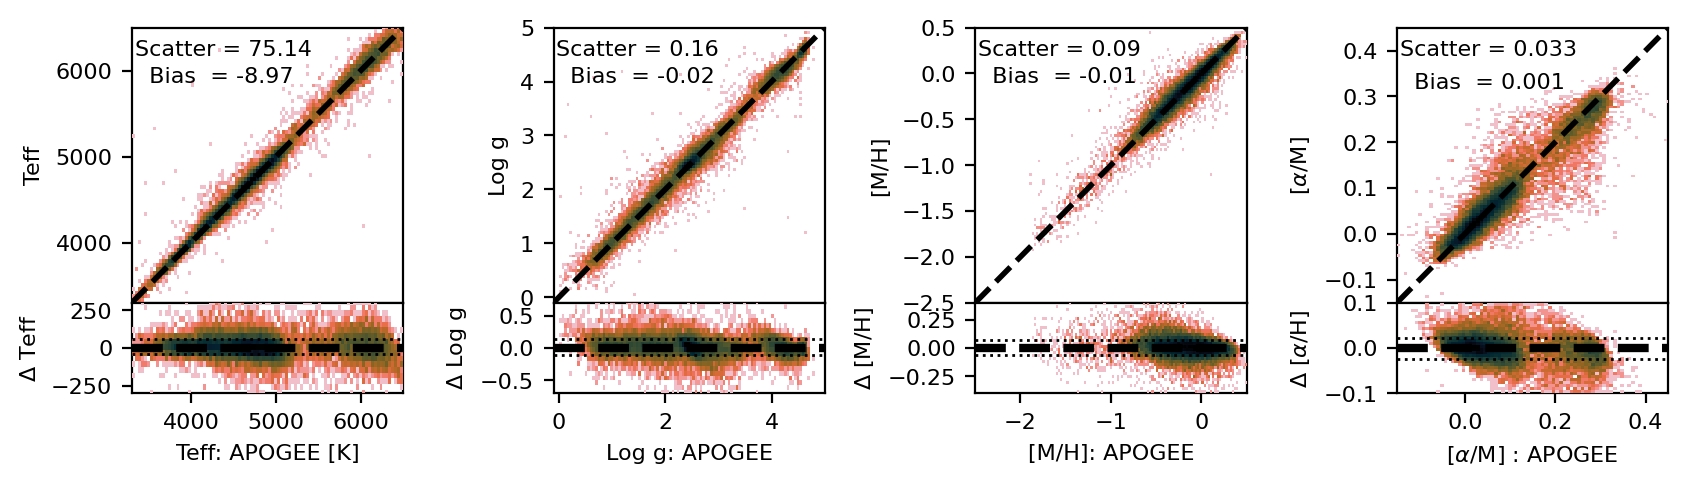

In [61]:
ind = rdf_xp['LOGG']<5

fig, axs = plt.subplots(1,4, figsize=(8.5, 2.5))

rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.4, 0.4], [-0.1, 0.1]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]
    
for i in range(4):
    ynames = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
    
    text_stats_default = False if i==3 else True

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_xp[ind][true_names[i]], rdf_xp[ind][ynames[i]],
        xrange=xranges[i], bins=100, text_stats=text_stats_default,
        cmap='cmr.dusk_r'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);
    
    if i==3:
        res = rdf_xp[ind][true_names[i]]-rdf_xp[ynames[i]]
        ax1.text(0.01, 0.9, "Scatter = %.3f"%(np.std(res)),
                transform=ax1.transAxes, zorder=6)
        ax1.text(0.01, 0.78, "  Bias  = %.3f"%(np.mean(res)),
                transform=ax1.transAxes, zorder=6)
    
plt.tight_layout()